In [1]:
import numpy as np
import pandas as pd
from numpy.random import normal as norm
from matplotlib import pyplot as plt
import random
import pickle
from fairsearchdeltr import Deltr
%matplotlib inline
from tqdm.notebook import tqdm

In [80]:
df = pd.read_csv('processed_data.csv')
df

color  gender  score
0          1       0  -2.08
1          1       0  -2.84
2          0       0  -1.20
3          0       1  -1.29
4          0       1  -2.90
...      ...     ...    ...
16387      1       0  -1.74
16388      1       0  -2.50
16389      1       0  -3.12
16390      0       0  -2.03
16391      1       0  -2.75

[16392 rows x 3 columns]

In [81]:
def sample_size(population, size):
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

def sample(df, strata, size=None, seed=None, keep_index= True):
    population = len(df)
    size = sample_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"

            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)

        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)

    return stratified_df.sample(frac=1).reset_index(drop=True)

In [82]:
def df_to_operating_tuple(df):
    return [(item['score'], (int(item['color']), int(item['gender']))) for index, item in df.iterrows()]

In [83]:
def add_additional_cols(df):
    df['q_id'] = 1
    df['doc_id'] = pd.Series(range(df.shape[0]))
    df['judgement'] = (df['score'] - df['score'].min()) / (df['score'].max() - df['score'].min())
    df = df[['q_id', 'doc_id', 'color', 'gender', 'score', 'judgement']]
    return df

In [84]:
# setup the DELTR object
protected_feature = "color"  # column name of the protected attribute (index after query and document id)
gamma = 3500  # value of the gamma parameter
number_of_iterations = 5  # number of iterations the training should run
standardize = True  # let's apply standardization to the features

# create the Deltr object
dtr = Deltr(protected_feature, gamma, number_of_iterations, standardize=standardize)

In [85]:
epoch = 5

for i in tqdm(range(epoch)):
    df_train = sample(df, ['color', 'gender'])
    df_train = add_additional_cols(df_train)
    df_without_gender = df_train[['q_id', 'doc_id', 'color', 'score', 'judgement']]
    dtr.train(df_without_gender)

  0%|          | 0/5 [00:00<?, ?it/s]

.
.
.
.
.


In [86]:
with open('dltr_compas_obj', 'wb') as obj_file:
    pickle.dump(dtr, obj_file)

In [87]:
dltr_saved: Deltr = None

with open('dltr_compas_obj', 'rb') as obj_file:
    dltr_saved = pickle.load(obj_file)

print(dltr_saved.log)

[<TrainStep [1643275739090,[-0.00070706  0.02708238],[[ 0.00338718 -0.0108379 ]
 [ 0.00338718 -0.0108379 ]
 [ 0.00338718 -0.0108379 ]
 ...
 [ 0.00338718 -0.0108379 ]
 [ 0.00338718 -0.0108379 ]
 [ 0.00338718 -0.0108379 ]],2094.944470827743,0.0]>, <TrainStep [1643275751195,[0.06398974 0.03318635],[[-0.03088153 -0.00291359]
 [-0.03088153 -0.00291359]
 [-0.03088153 -0.00291359]
 ...
 [-0.03088153 -0.00291359]
 [-0.03088153 -0.00291359]
 [-0.03088153 -0.00291359]],2094.406693013185,0.01567109228268866]>, <TrainStep [1643275764877,[0.05371315 0.05491134],[[ 0.00490529 -0.01036992]
 [ 0.00490529 -0.01036992]
 [ 0.00490529 -0.01036992]
 ...
 [ 0.00490529 -0.01036992]
 [ 0.00490529 -0.01036992]
 [ 0.00490529 -0.01036992]],2094.8047423667,0.0]>, <TrainStep [1643275777980,[0.04469031 0.07452456],[[ 0.00430684 -0.00936192]
 [ 0.00430684 -0.00936192]
 [ 0.00430684 -0.00936192]
 ...
 [ 0.00430684 -0.00936192]
 [ 0.00430684 -0.00936192]
 [ 0.00430684 -0.00936192]],2094.256540256869,0.0]>, <TrainStep 

In [88]:
rnk_w_g = dltr_saved.rank(df_without_gender[['q_id', 'doc_id', 'color', 'score']])
rnk_w_g.head(5)

doc_id  color  judgement
529      529      0   0.143231
1371    1371      1   0.081691
546      546      1   0.073166
831      831      0   0.072759
661      661      1   0.072029

In [89]:
def getTopDebiased(data, top=0.1):
    df = data.copy()
    items = dltr_saved.rank(df[['q_id', 'doc_id', 'color', 'score']])[:int(df.shape[0] * top)]
    return [(df.loc[index]['score'], (int(df.loc[index]['color']), int(df.loc[index]['gender']))) for index, _ in items.iterrows()]

In [90]:
# return individuals with top percieved qualities
def getTop(df, top = 0.1):
    data = df.copy().sort_values(['score'], ascending=[0])
    items = data[:int(data.shape[0] * top)]
    return df_to_operating_tuple(items)

In [91]:
# Compute chances to be in top k% for aggregated groups before and after debiasing
# d => fixed biases []
# f => number of elements
def get_aggregated(data, N, Nsim, k_range):
    results = {'original': {0: [], 1: []},
               'debiased': {0: [], 1: []}}

    # shapes(invisible) => 0: circle; 1: stars
    # colors(visible) => 0: orange; 1: green
    groups = [0, 1]

    for k in k_range:
        simulations = {'original': {0: [], 1: []},
                       'debiased': {0: [], 1: []}}

        for i in tqdm(range(0, Nsim), desc='Simulations for top {}'.format(k*100)):

            # properties, perceived qualities and real qualities
            df_gen = sample(data, ['color', 'gender'], N)
            df_gen = add_additional_cols(df_gen)

            for group in groups:

                # compute expected chances to be in top
                exp = df_gen[(df_gen['color'] == group)].shape[0] / df_gen.shape[0]

                for approach in ['original', 'debiased']:

                    if approach == 'original':
                        top = getTop(df_gen, k)
                    else:
                        top = getTopDebiased(df_gen, k)

                    # compute real chances to be in top
                    real = len([x for x in top if x[1][0] == group]) / len(top)

                    rep_bias = (real - exp) / exp
                    simulations[approach][group].append(rep_bias)

        for group in [0, 1]:
            for approach in ['original', 'debiased']:
                results[approach][group].append(np.mean(simulations[approach][group]))
    return results

In [92]:
def plot_aggregated(results):
    colors = ['orange', 'green']
    styles = {'original': '-', 'debiased': '--'}

    for approach in ['original', 'debiased']:
        for group in [0, 1]:
            plt.plot(k_range, results[approach][group], color = colors[group], ls = styles[approach])
    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

In [93]:
# for quick results
Nsim = 5
print('Number of Simulations : ', Nsim)

# to fetch top k% candidates
k_range = [i / 100 for i in range(1, 101, 5)]
print('Ranking Indexes : ', k_range)

Number of Simulations :  5
Ranking Indexes :  [0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51, 0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96]


Simulations for top 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

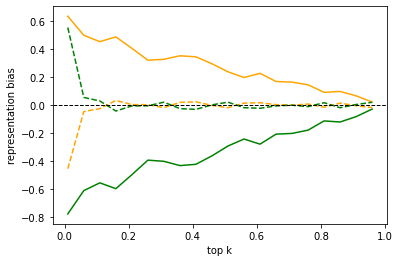

In [94]:
results_agg = get_aggregated(df, 400, Nsim, k_range)
plot_aggregated(results_agg)

In [95]:
# Compute chances to be in top k% for disaggregated groups before and after debiasing
def get_disaggregated(data, N, Nsim, k_range):
    groups = [(0,0),(0,1),(1,0),(1,1)]

    results = {'original': {g:[] for g in groups},
               'debiased': {g:[] for g in groups}}

    for k in k_range:
        simulations = {'original': {g:[] for g in groups},
                       'debiased': {g:[] for g in groups}}

        for i in tqdm(range(0, Nsim), desc='Simulations for top {}'.format(k*100)):
            df_gen = sample(data, ['color', 'gender'], N)
            df_gen = add_additional_cols(df_gen)

            for g in groups:
                # compute expected chances to be in top
                exp = df_gen[(df_gen['color'] == g[0]) & (df_gen['gender'] == g[1])].shape[0] / df_gen.shape[0]
                for approach in ['original', 'debiased']:
                    if approach == 'original':
                       top = getTop(df_gen, k)
                    else:
                       top = getTopDebiased(df_gen, k)

                    # compute real chances to be in top
                    real = len([x for x in top if x[1] == g]) / len(top)
                    simulations[approach][g].append((real - exp) / exp)

        for g in groups:
            for approach in ['original', 'debiased']:
                results[approach][g].append(np.mean(simulations[approach][g]))
    return results

In [96]:
def plot_disaggregated(results):
    groups = [(0,0),(0,1),(1,0),(1,1)]
    fill = {'original': 'full', 'debiased': 'none'}
    colors = ['orange', 'green']
    shapes = ['o', '*']
    for g in groups:
        for approach in ['original', 'debiased']:
            plt.plot(k_range, results[approach][g], shapes[g[1]], color = colors[g[0]], lw = 2, fillstyle = fill[approach])
    plt.axhline(0, color='k', linestyle='dashed', linewidth=1)
    plt.fill_between(k_range, results['debiased'][(0,1)], results['original'][(0,1)], color='orange', alpha=.25)
    plt.xlabel('top k')
    plt.ylabel('representation bias')

Simulations for top 1.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 6.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 11.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 16.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 21.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 26.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 31.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 36.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 41.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 46.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 51.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 56.00000000000001:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 61.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 66.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 71.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 76.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 81.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 86.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 91.0:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations for top 96.0:   0%|          | 0/5 [00:00<?, ?it/s]

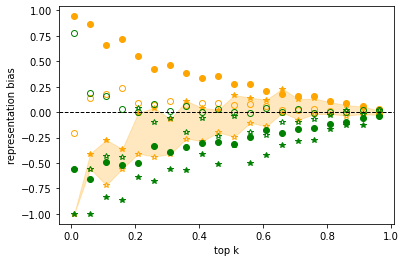

In [97]:
results_dis_agg = get_disaggregated(df, 400, Nsim, k_range)
plot_disaggregated(results_dis_agg)

In [99]:
np.save('results_deltr_compas.npy', {'agg': results_agg, 'diss_agg': results_dis_agg})

In [100]:
read_dictionary = np.load('results_deltr_compas.npy', allow_pickle='TRUE').item()
read_dictionary

{'agg': {'original': {0: [0.6363636363636361,
    0.4999999999999999,
    0.4545454545454544,
    0.4886363636363635,
    0.40692640692640686,
    0.32167832167832155,
    0.32844574780058644,
    0.3535353535353534,
    0.3458980044345897,
    0.29644268774703547,
    0.23885918003565054,
    0.19805194805194803,
    0.22801788375558862,
    0.16942148760330564,
    0.16517285531370032,
    0.14593301435406691,
    0.09203142536475861,
    0.09830866807610979,
    0.06693306693306689,
    0.022727272727272645],
   1: [-0.7777777777777779,
    -0.611111111111111,
    -0.5555555555555556,
    -0.5972222222222221,
    -0.4973544973544974,
    -0.3931623931623932,
    -0.40143369175627236,
    -0.4320987654320988,
    -0.4227642276422764,
    -0.3623188405797102,
    -0.2919389978213508,
    -0.2420634920634921,
    -0.27868852459016397,
    -0.2070707070707071,
    -0.2018779342723005,
    -0.17836257309941517,
    -0.112482853223594,
    -0.12015503875968996,
    -0.08180708180708182,
 